http://preview.d2l.ai/d2l-en/master/chapter_recommender-systems/neumf.html

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
import mxnet as mx
import random
import sys
npx.set_np()

In [2]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(nn.Dense(num_hiddens, activation='relu',
                                  use_bias=True))

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return np.sum(con_res, axis=-1)

In [3]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [4]:
#@save
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

In [5]:
#@save
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(
            gluon.data.ArrayDataset(*x), shuffle=False, last_batch="keep",
            batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [gluon.utils.split_and_load(v, devices, even_split=False)
                 for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

In [6]:
#@save
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [net(*t) for t in zip(*input_data[0:-2],
                                              input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean()/len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [7]:
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items ), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

In [8]:
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

train loss 8.281, test hit rate 0.333, test AUC 0.735
9.4 examples/sec on [cpu(0)]


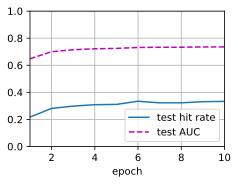

In [9]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)